# Ejemplo de RNN sencilla con pytorch

Vamos a escribir el código necesario para hacer una RNN con pytorch y probarla con un dataset sencillo.

## Generación del dataset

Primero, vamos a generar una serie creciente con un poco de ruido para entrenar nuestra red neuronal recurrente. Usaremos una secuencia de valores entre 1 y 10, y agregaremos algo de ruido aleatorio para que el problema sea un poco más realista.

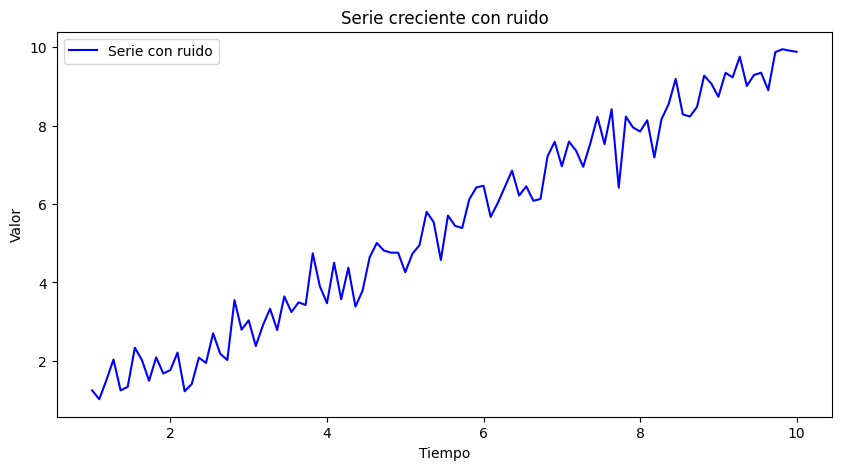

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generamos una serie creciente simple con ruido
np.random.seed(42)
x_series = np.linspace(1, 10, 100)
noise = np.random.normal(0, 0.5, x_series.shape)
y_series = x_series + noise

# Graficamos la serie generada
plt.figure(figsize=(10, 5))
plt.plot(x_series, y_series, label='Serie con ruido', color='b')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie creciente con ruido')
plt.legend()
plt.show()


## Preparación del dataset

Necesitamos preparar los datos para que sean compatibles con PyTorch. Esto incluye convertir los datos en tensores y crear secuencias para entrenar la RNN.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convertir los datos a tensores de PyTorch
x_series_tensor = torch.tensor(y_series[:-1], dtype=torch.float32).view(-1, 1)
y_series_tensor = torch.tensor(y_series[1:], dtype=torch.float32).view(-1, 1)

# Crear un conjunto de datos y un DataLoader
dataset = TensorDataset(x_series_tensor, y_series_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)




## Definimos la red recurrente

Definimos una clase que hereda de nn.Module para nuestra RNN. Utilizaremos la capa nn.RNN proporcionada por PyTorch.

In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        
        # Definición de la capa RNN
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
        # Capa lineal para mapear del espacio oculto al espacio de salida
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h_prev=None):
        if h_prev is None:
            h_prev = torch.zeros(1, x.size(0), self.hidden_size)
        out, h_next = self.rnn(x, h_prev)
        out = self.fc(out)
        return out, h_next


### Inicialización del modelo, criterio y optimizador

Creamos una instancia del modelo, definimos la función de pérdida y el optimizador.

In [9]:
# Hiperparámetros
input_size = 1
hidden_size = 10
output_size = 1
learning_rate = 0.01
num_epochs = 200

# Inicialización del modelo
model = RNNModel(input_size, hidden_size, output_size)

# Definición del criterio de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Entrenamiento del modelo

Definimos el bucle de entrenamiento para actualizar los pesos del modelo.

In [10]:
# Inicialización del estado oculto
h_prev = torch.zeros(1, 1, hidden_size)

# Lista para almacenar la pérdida en cada época
loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.unsqueeze(1)  # Tamaño: (batch_size, seq_length, input_size)
        y_batch = y_batch.unsqueeze(1)  # Tamaño: (batch_size, seq_length, output_size)
        
        optimizer.zero_grad()
        
        # Forward pass
        output, _ = model(x_batch)
        
        # Cálculo de la pérdida
        loss = criterion(output, y_batch)
        total_loss += loss.item()
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()

    
    # Almacenar la pérdida promedio
    avg_loss = total_loss / len(dataloader)
    loss_list.append(avg_loss)
    
    # Mostrar la pérdida cada 20 épocas
    if (epoch + 1) % 20 == 0:
        print(f'Época [{epoch + 1}/{num_epochs}], Pérdida: {avg_loss:.4f}')

Época [20/200], Pérdida: 0.9541
Época [40/200], Pérdida: 0.5376
Época [60/200], Pérdida: 0.4245
Época [80/200], Pérdida: 0.4705
Época [100/200], Pérdida: 0.5357
Época [120/200], Pérdida: 0.4163
Época [140/200], Pérdida: 0.5674
Época [160/200], Pérdida: 0.3747
Época [180/200], Pérdida: 0.4281
Época [200/200], Pérdida: 0.4259


## Evaluamos los resultados

Una vez procesada la secuencia, evaluaremos los resultados. Para esto, compararemos las salidas generadas por la RNN con los valores reales de la serie.

In [ ]:
# Evaluación del modelo entrenado
model.eval()

with torch.no_grad():
    inputs = torch.tensor(y_series[:-1], dtype=torch.float32).view(-1, 1, 1)
    targets = torch.tensor(y_series[1:], dtype=torch.float32).view(-1, 1)
    
    # Forward pass
    outputs, _ = model(inputs)
    outputs = outputs.view(-1).numpy()
    targets = targets.view(-1).numpy()

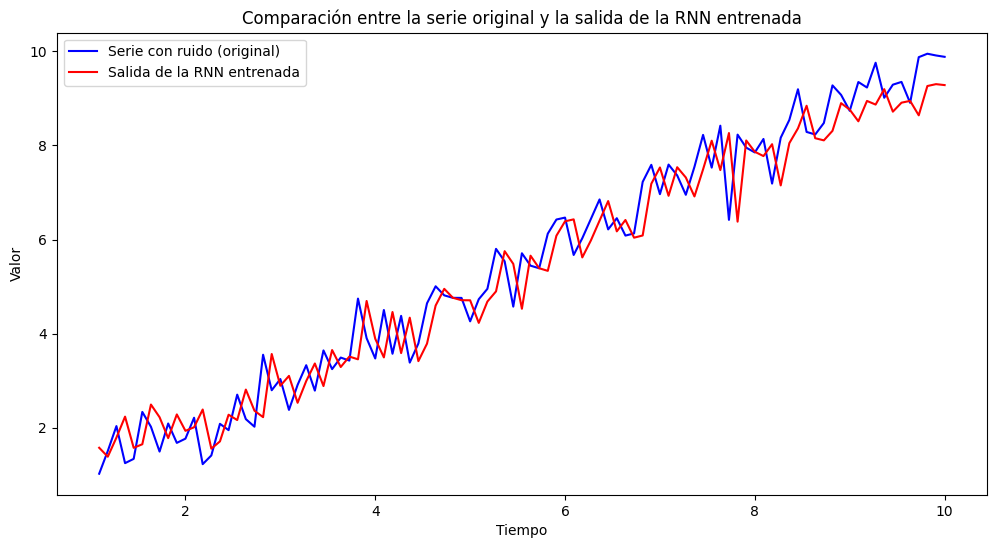

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(x_series[1:], y_series[1:], label='Serie con ruido (original)', color='b')
plt.plot(x_series[1:], outputs, label='Salida de la RNN entrenada', color='r')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Comparación entre la serie original y la salida de la RNN entrenada')
plt.legend()
plt.show()


## Predicción a futuro

In [13]:
# Predicción de valores futuros
future_steps = 50
predictions = []

# Usamos el último valor de entrada y el último estado oculto
last_input = torch.tensor(y_series[-1], dtype=torch.float32).view(1, 1, 1)
h_prev = h_prev.detach()

with torch.no_grad():
    for _ in range(future_steps):
        # Forward pass
        output, h_prev = model(last_input, h_prev)
        predictions.append(output.item())
        
        # La salida actual se convierte en la entrada para el próximo paso
        last_input = output.view(1, 1, 1)


Creamos el eje temporal para las predicciones futuras

In [14]:
# Calculamos el tamaño del paso temporal en la serie original
delta_t = (x_series[-1] - x_series[0]) / (len(x_series) - 1)

# Creamos un eje de tiempo extendido a partir del último valor de la serie original
t_extended = [x_series[-1] + delta_t * (i + 1) for i in range(future_steps)]


Visualizamos las predicciones

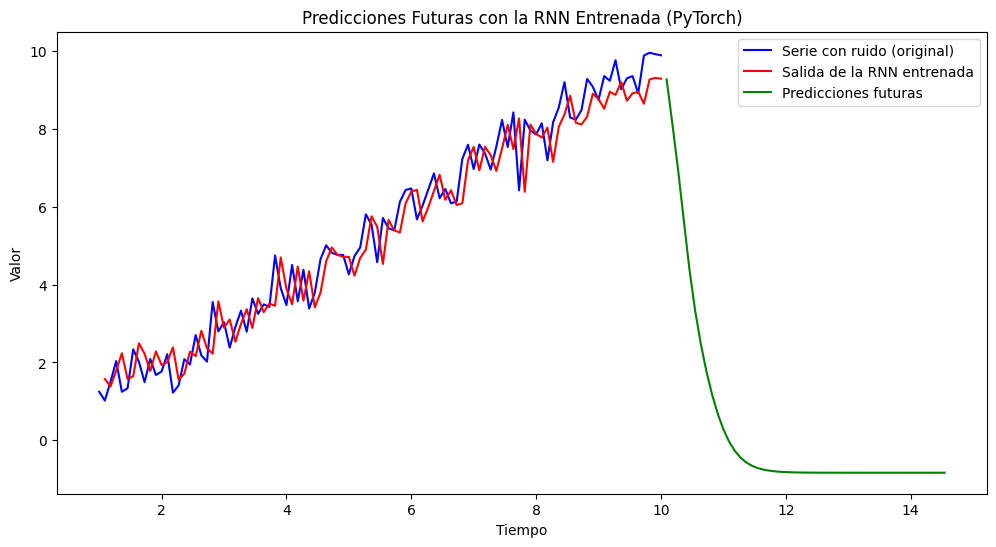

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(x_series, y_series, label='Serie con ruido (original)', color='b')
plt.plot(x_series[1:], outputs, label='Salida de la RNN entrenada', color='r')
plt.plot(t_extended, predictions, label='Predicciones futuras', color='g')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicciones Futuras con la RNN Entrenada (PyTorch)')
plt.legend()
plt.show()
